In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

In [2]:
# import dataset
ds = xr.open_dataset('residence_time.nc') # Path to final dataset

In [3]:
# colormap

def colormap_vintage():
    cmap = 'RdYlBu_r'
    cmap_values = plt.get_cmap(cmap)(np.linspace(0.05,1.,256))
    #darken cmap_values
    cmap_values = np.minimum(cmap_values*(1.0-np.sin(
        np.arange(len(cmap_values))*np.pi/(len(cmap_values)-1))\
        *0.05)[:,np.newaxis],1.)
    white_weight = np.linspace(1.,0.,50)[:,np.newaxis]
    gamma = 1/0.8
    white_values = np.array([1.0,1.0,1.0,0.0])*white_weight**gamma \
         + cmap_values[0,:]*(1-white_weight**gamma)
    new_cmap_values = np.vstack([white_values, cmap_values])
    newcmap = mcolors.LinearSegmentedColormap.from_list(
        cmap+'_white100',new_cmap_values)

    return newcmap

In [4]:
save = False # Set to True to save figures

## Figure 1

In [5]:
def plot_statistic(statistic, savename, save, step, maximum, title):
    '''
    (work in progress)
    
    Parameters:
        statistic (arr): Array to be plotted
        savename (str): Name of the figure that is going to be saved
    Returns:
        None
    '''
    resolution = 0.5
    lon = np.arange(-180, 180, step=resolution) + 0.25
    lat = np.arange(-90, 90, step=resolution) + 0.25
    
    statistic_zeros_replaced = np.where(statistic == 0, np.nan, statistic)
    
    map_proj = ccrs.PlateCarree()
    data_crs = ccrs.PlateCarree()
    
    fig, ax = plt.subplots(
    figsize=(13, 6), layout="compressed", dpi=100,
    subplot_kw=dict(projection=map_proj), facecolor='w'
    )
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=['bottom', 'left'],
                      color='gray', alpha=0.5, linestyle='--', lw=.8)
    gl.xlocator = LongitudeLocator()
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlocator = mticker.MaxNLocator(12)
    gl.ylocator = mticker.MaxNLocator(6)
    gl.xlabel_style = {'fontsize': 'large', 'rotation': 45}
    gl.ylabel_style = {'fontsize': 'large'}
    
    ax.text(-0.08, 0.55, r'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize='large')
    ax.text(0.5, -0.2, r'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize='large')
    ax.set_title(title, fontsize='large')
    
    #levels = np.arange(-step, maximum, step=step)
    levels = np.arange(0, maximum+step, step=step)
    cmap = colormap_vintage()
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    ax.coastlines(resolution='110m', color='k', lw=.5, alpha=.5)
    ax.add_feature(cfeature.BORDERS, ec='k', lw=.5, alpha=.5)
    #im = ax.contourf(lon, lat, statistic, transform=data_crs, cmap=colormap_vintage(), levels=np.concatenate((np.array([0, 0.1]), np.arange(5, 210, step=20, dtype=float))))
    im = ax.pcolormesh(lon, lat, statistic_zeros_replaced, cmap=cmap, norm=norm, transform=data_crs, shading='nearest', linewidth=0, rasterized=True, alpha=1)
    #ax.scatter([16], [4], marker='x', color='red', s=50)
    cbar = plt.colorbar(im, ax=ax, shrink=0.9, ticks=levels[::2], extend='max', pad=0.01, aspect=22.5)
    cbar.ax.tick_params(labelsize='large')
    cbar.set_label(r'Lagrangian Continentality, $[d]$', fontsize='large')
    #cbar.ax.set_ylim(0, 211, norm=norm)
    if save:
        fig.savefig(savename, dpi=300, bbox_inches='tight')
    elif not save:
        plt.show() 
    return None

In [6]:
ds_annual = ds.mean(dim='time')
ds_annual_short = ds.sel(time=slice(datetime(1980, 1, 1), datetime(2024, 1, 1))).mean(dim='time')

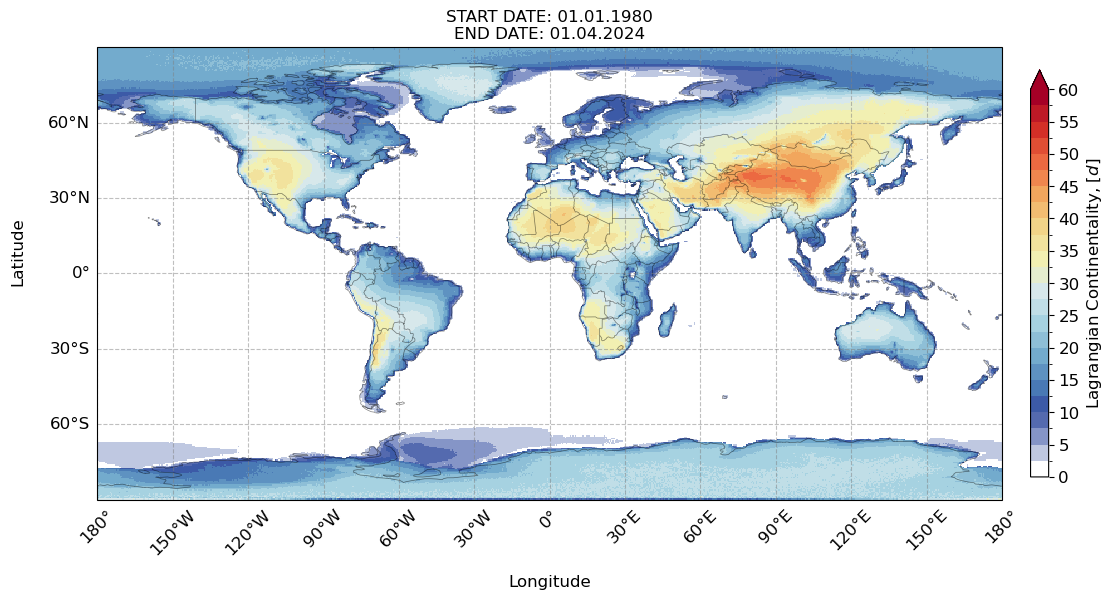

In [7]:
plot_statistic(ds_annual_short.traveltime_mean/24, 'Fig_1_short.pdf', save, 2.5, 60, 'START DATE: 01.01.1980\nEND DATE: 01.04.2024')

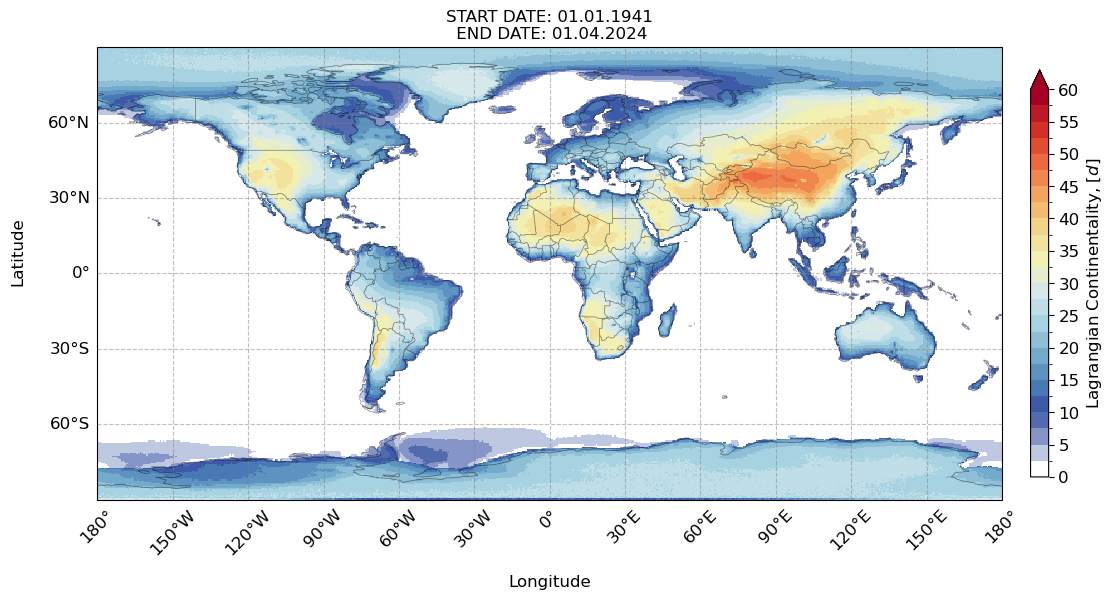

In [8]:
plot_statistic(ds_annual.traveltime_mean/24, 'Fig_1.pdf', save, 2.5, 60, 'START DATE: 01.01.1941\n END DATE: 01.04.2024')

## Figure 2

In [9]:
def plot_seasonal(statistic, savename, save, step, maximum, title):
    resolution = 0.5
    lon = np.arange(-180, 180, step=resolution) + 0.25
    lat = np.arange(-90, 90, step=resolution) + 0.25
    
    map_proj = ccrs.PlateCarree()
    data_crs = ccrs.PlateCarree()
    
    traveltime_mean_seasonal = []
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    images = []
    
    #levels = np.arange(-step, maximum, step=step)
    levels = np.arange(0, maximum+step, step=step)
    cmap = colormap_vintage()
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 6.5),
                           layout='compressed',
                           dpi=100,
                           subplot_kw=dict(projection=map_proj),
                           facecolor='w'
                           )
    
    for i in range(len(seasons) - 2):
        for o in range(len(seasons) - 2):
            im = ax[i][o].pcolormesh(lon, lat,
                                     statistic.sel(season=seasons[2*i+o]),
                                     cmap=cmap,
                                     norm=norm,
                                     transform=data_crs,
                                     shading='nearest',
                                     linewidth=0,
                                     rasterized=True,
                                     alpha=1)
            images.append(im)
            ax[i][o].set_title(seasons[2*i+o], fontweight='bold', fontsize=12)
            gl = ax[i][o].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                    color='gray', alpha=0.5, linestyle='--', lw=.8)
            
            gl.xlocator = mticker.MaxNLocator(6)
            gl.xlocator = LongitudeLocator()
            gl.ylocator = LatitudeLocator()
            gl.xformatter = LongitudeFormatter()
            gl.yformatter = LatitudeFormatter()
            gl.top_labels = False
            gl.bottom_labels = False
            gl.left_labels = False
            gl.right_labels = False

            ax[i][o].coastlines(resolution='110m', color='k', lw=.5, alpha=.5)
            ax[i][o].add_feature(cfeature.BORDERS, ec='k', lw=.5, alpha=.5)
            
            
            if i == 1:
                gl.bottom_labels = True
            if o == 0:
                gl.left_labels = True
            
            gl.xlocator = mticker.MaxNLocator(6)
            gl.ylocator = mticker.MaxNLocator(6)
            gl.xlabel_style = {'size': 11}
            gl.ylabel_style = {'size': 11}
            
            subplot_label = f"({chr(ord('a') + 2*i + o)})" 
            ax[i][o].text(-175, 85, subplot_label, 
                          transform=map_proj, 
                          fontsize=12, 
                          fontweight='bold', 
                          va='top', 
                          ha='left')
            
    fig.suptitle(title)
    fig.supylabel('Latitude')
    fig.supxlabel('Longitude')
    
    cbar = fig.colorbar(images[-1], ax=ax, location='right',
                        shrink=0.9, ticks=levels[::2],
                        extend='max',
                        aspect=22.5,
                        pad=0.02)
    cbar.ax.tick_params(labelsize='large')
    cbar.set_label(r'Lagrangian Continentality, $[d]$', fontsize='large')
    
    
    
    if save:
        fig.savefig(savename, dpi=300, bbox_inches='tight')
    elif not save:
        plt.show()
    
    return None

In [10]:
ds_seasonal_short = ds.sel(time=slice(datetime(1980, 1, 1), datetime(2024, 3, 15))).groupby('season').mean(dim='time')
ds_seasonal = ds.groupby('season').mean(dim='time')

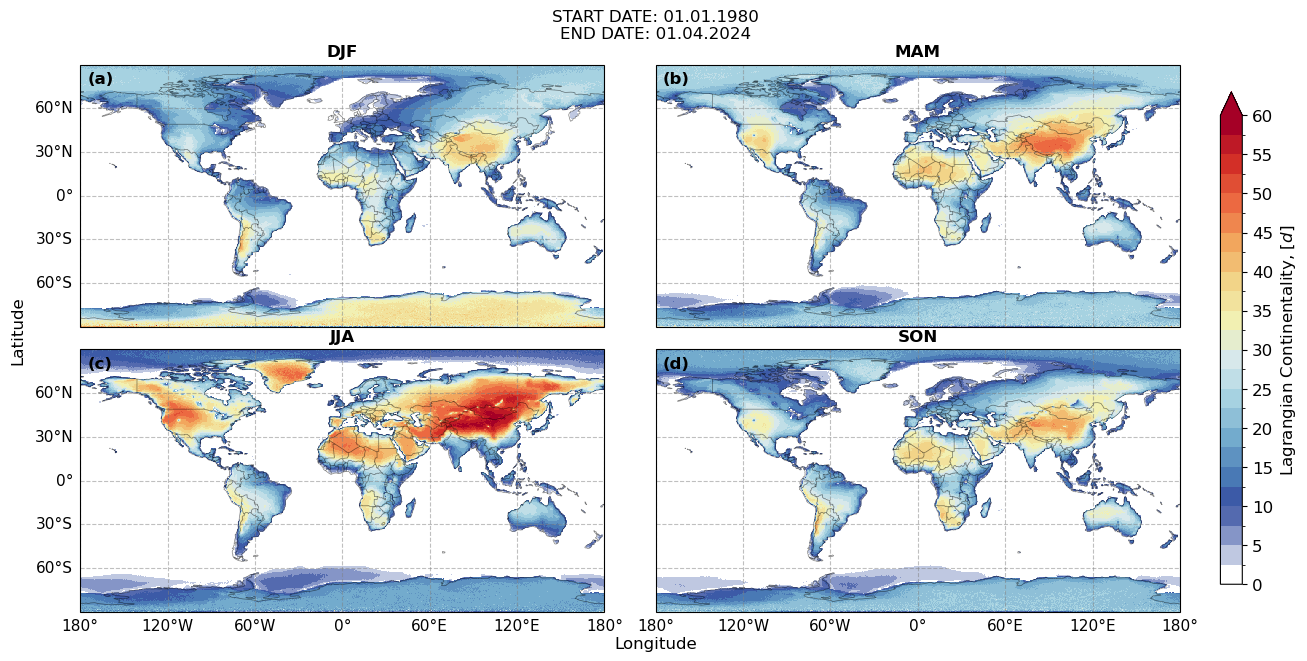

In [11]:
plot_seasonal(ds_seasonal_short.traveltime_mean/24, 'Fig_2_short.pdf', save, 2.5, 60, 'START DATE: 01.01.1980\nEND DATE: 01.04.2024')

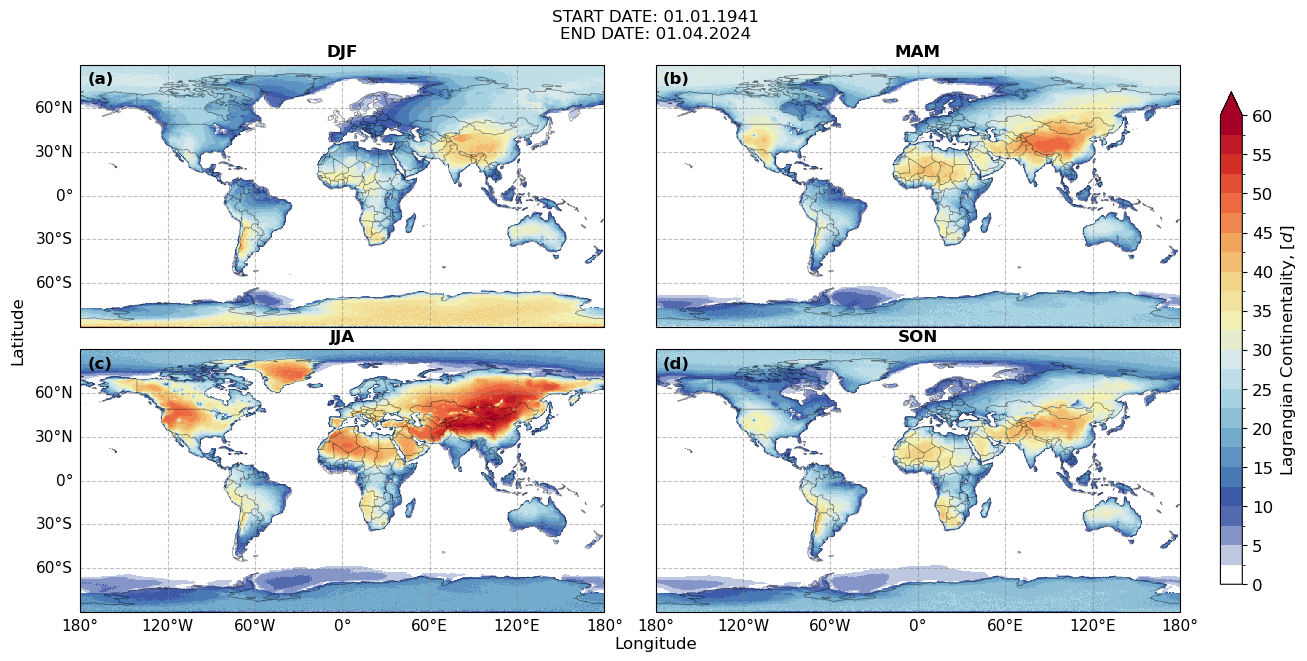

In [12]:
plot_seasonal(ds_seasonal.traveltime_mean/24, 'Fig_2.pdf', save, 2.5, 60, 'START DATE: 01.01.1941\nEND DATE: 01.04.2024')